# Model Monitoring & Performance Tracking for Fashion MNIST

This notebook demonstrates model monitoring and performance tracking techniques for the Fashion MNIST dataset.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import mlflow
import mlflow.sklearn
from datetime import datetime
from sklearn.model_selection import train_test_split

# Add the src directory to the path
sys.path.append('../')

# Import project modules
from src.data.load_data import load_fashion_mnist
from src.data.preprocess import prepare_data_for_modeling
from src.models.train_model import load_saved_model
from src.models.evaluate_model import evaluate_model, plot_confusion_matrix
from src.models.monitoring import (
    load_config,
    setup_mlflow,
    log_model_params,
    log_model_metrics,
    log_model,
    log_artifact,
    detect_feature_drift,
    detect_performance_drift,
    plot_drift_detection,
    plot_metrics_over_time,
    evaluate_and_log_metrics
)

# Set random seed for reproducibility
np.random.seed(42)

2025-03-21 18:01:04.306341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 18:01:04.314690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742560264.324099  306201 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742560264.326902  306201 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 18:01:04.337061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 1. Load Configuration

In [2]:
# Load configuration
config = load_config('../configs/monitoring_config.yaml')
print(f"Loaded monitoring configuration")

Loaded monitoring configuration


## 2. Load and Preprocess the Fashion MNIST Dataset

In [3]:
# Load the dataset
(x_train, y_train), (x_test, y_test), class_names = load_fashion_mnist(save_to_disk=True)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Class names: {class_names}")

Dataset saved to ../data/raw
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
# Preprocess the data
x_train_prep, y_train_prep, x_test_prep, y_test_prep = prepare_data_for_modeling(
    x_train, y_train, x_test, y_test, normalize=True
)

# Flatten the data for traditional ML models
x_train_flat = x_train_prep.reshape(x_train_prep.shape[0], -1)
x_test_flat = x_test_prep.reshape(x_test_prep.shape[0], -1)

print(f"Preprocessed training data shape: {x_train_flat.shape}")
print(f"Preprocessed test data shape: {x_test_flat.shape}")

Preprocessed training data shape: (60000, 784)
Preprocessed test data shape: (10000, 784)


## 3. Set Up MLflow Tracking

In [5]:
# Set up MLflow tracking
run_id = setup_mlflow(
    tracking_uri=config['mlflow']['tracking_uri'],
    experiment_name=config['mlflow']['experiment_name'],
    run_name=config['mlflow']['run_name'],
    tags=config['mlflow']['tags']
)

MLflow run started: f86d33417e5444fd8f46c63b7b4e0063
Experiment: fashion-mnist
Run name: baseline


## 4. Load the Best Model

We'll load the best model from our previous model selection process.

In [6]:
# Load the best model
try:
    # Try to load the optimized model first
    model = load_saved_model('optimized_model.pkl')
    model_name = 'optimized_model'
except FileNotFoundError:
    try:
        # Try to load the automl model next
        model = load_saved_model('automl_model.pkl')
        model_name = 'automl_model'
    except FileNotFoundError:
        try:
            # Try to load the random forest model next
            model = load_saved_model('random_forest_baseline.pkl')
            model_name = 'random_forest_baseline'
        except FileNotFoundError:
            # If no model is found, raise an error
            raise FileNotFoundError("No trained model found. Please run the model selection notebook first.")

print(f"Loaded model: {model_name}")

# Log model parameters to MLflow
log_model_params(model.get_params())

Model loaded from ../models/optimized_model.pkl
Loaded model: optimized_model


## 5. Evaluate Model Performance

Let's evaluate the model's performance on the test set and log the metrics to MLflow.


=== Model Performance on Test Set ===

Confusion matrix saved to ../reports/figures/monitoring_confusion_matrix.png


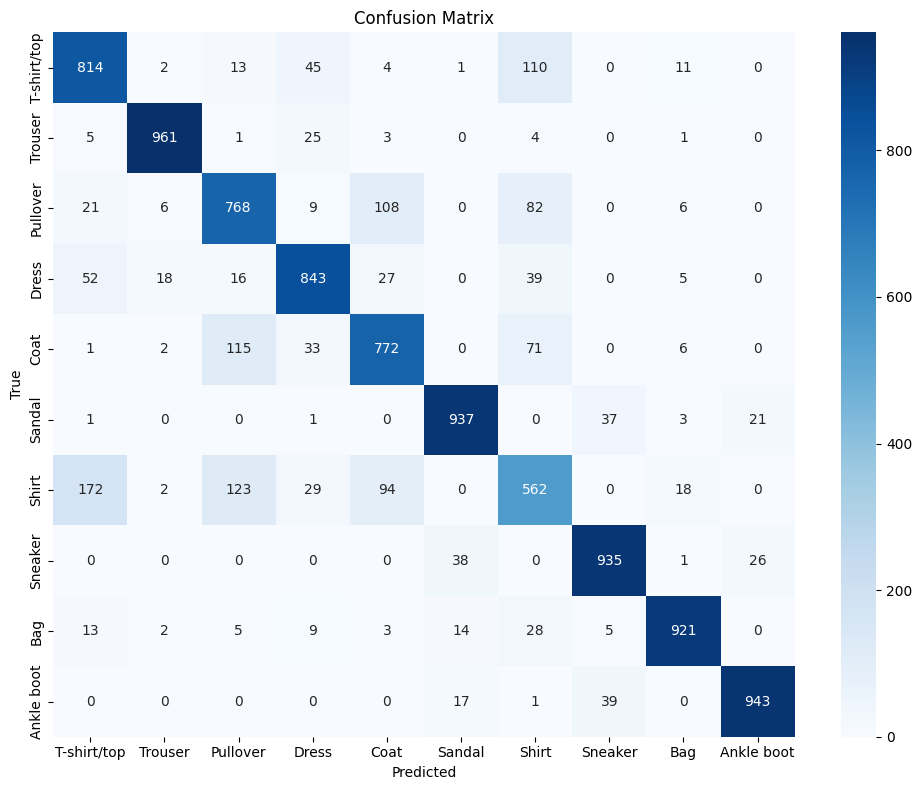

In [7]:
# Evaluate model performance
print("\n=== Model Performance on Test Set ===\n")
metrics = evaluate_and_log_metrics(model, x_test_flat, y_test_prep)  # No need to pass run_id

# Plot confusion matrix
cm = plot_confusion_matrix(model, x_test_flat, y_test_prep, class_names,
                         output_file='../reports/figures/monitoring_confusion_matrix.png')

# Log confusion matrix to MLflow
log_artifact('../reports/figures/monitoring_confusion_matrix.png')

## 6. Feature Drift Detection

Let's simulate feature drift by adding noise to the test data and detect it.

In [8]:
# Simulate feature drift by adding noise to test data
np.random.seed(42)

# Create different levels of drift
drift_levels = [0.0, 0.05, 0.1, 0.2, 0.5]
drift_results = []

for noise_level in drift_levels:
    # Add noise to test data
    x_test_drift = x_test_flat + np.random.normal(0, noise_level, x_test_flat.shape)
    
    # Detect feature drift
    drift_detected, drift_scores = detect_feature_drift(
        x_train_flat, x_test_drift, 
        method=config['drift_detection']['feature_drift']['method'],
        threshold=config['drift_detection']['feature_drift']['threshold']
    )
    
    # Store results
    drift_results.append({
        'noise_level': noise_level,
        'drift_detected': drift_detected,
        'drift_scores': drift_scores,
        'percent_features_drifted': np.mean(drift_scores < config['drift_detection']['feature_drift']['threshold']) * 100
    })
    
    print(f"Noise level: {noise_level}, Feature drift detected: {drift_detected}, "  
          f"Percent features drifted: {drift_results[-1]['percent_features_drifted']:.2f}%")

Noise level: 0.0, Feature drift detected: True, Percent features drifted: 0.89%
Noise level: 0.05, Feature drift detected: True, Percent features drifted: 100.00%
Noise level: 0.1, Feature drift detected: True, Percent features drifted: 100.00%
Noise level: 0.2, Feature drift detected: True, Percent features drifted: 100.00%
Noise level: 0.5, Feature drift detected: True, Percent features drifted: 100.00%


Drift detection plot saved to ../reports/figures/feature_drift.png


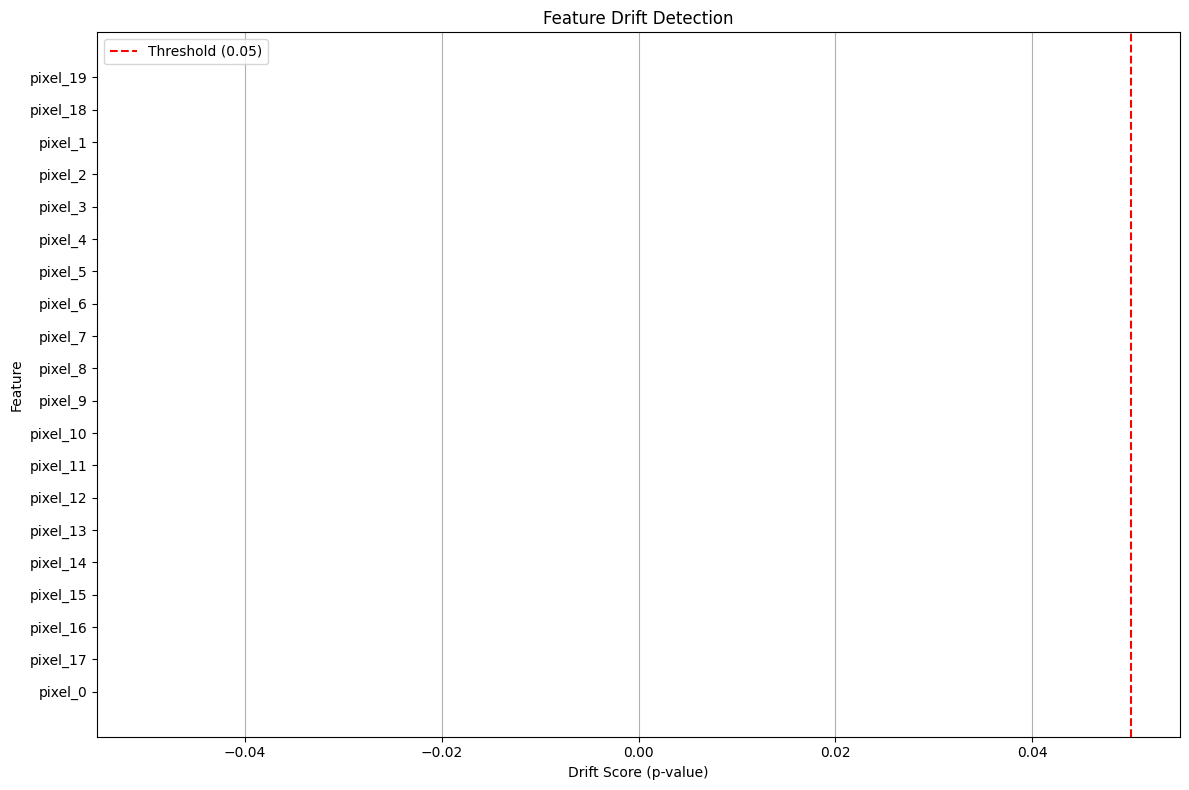

In [9]:
# Plot feature drift for the highest noise level
highest_drift = drift_results[-1]
feature_names = [f"pixel_{i}" for i in range(min(20, x_train_flat.shape[1]))]

drift_df = plot_drift_detection(
    highest_drift['drift_scores'][:20], feature_names, 
    threshold=config['drift_detection']['feature_drift']['threshold'],
    output_file='../reports/figures/feature_drift.png'
)

# Log drift detection plot to MLflow
log_artifact('../reports/figures/feature_drift.png')

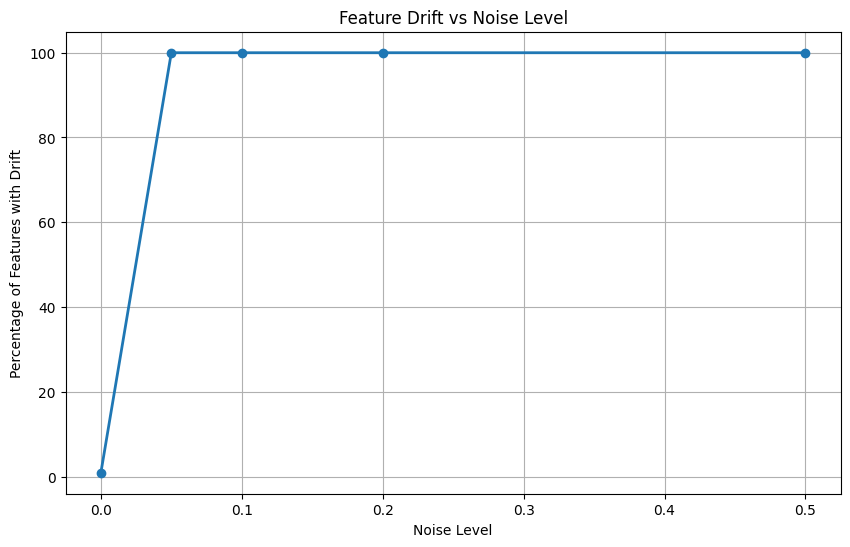

In [10]:
# Plot percentage of drifted features vs noise level
plt.figure(figsize=(10, 6))
plt.plot([d['noise_level'] for d in drift_results], 
         [d['percent_features_drifted'] for d in drift_results], 
         marker='o', linewidth=2)
plt.xlabel('Noise Level')
plt.ylabel('Percentage of Features with Drift')
plt.title('Feature Drift vs Noise Level')
plt.grid(True)
plt.savefig('../reports/figures/drift_vs_noise.png', dpi=300, bbox_inches='tight')
plt.show()

# Log plot to MLflow
log_artifact('../reports/figures/drift_vs_noise.png')

## 7. Performance Drift Detection

Let's evaluate how model performance changes as data drift increases.

In [11]:
# Evaluate performance on drifted data
performance_results = []

# Get baseline metrics on original test data
baseline_metrics = evaluate_model(model, x_test_flat, y_test_prep, class_names)
performance_results.append({
    'noise_level': 0.0,
    **baseline_metrics
})

# Evaluate on drifted data with different noise levels
for noise_level in [0.05, 0.1, 0.2, 0.5]:
    # Add noise to test data
    x_test_drift = x_test_flat + np.random.normal(0, noise_level, x_test_flat.shape)
    
    # Evaluate model on drifted data
    drift_metrics = evaluate_model(model, x_test_drift, y_test_prep, class_names)
    
    # Detect performance drift
    perf_drift_detected, perf_drift_scores = detect_performance_drift(
        baseline_metrics, drift_metrics,
        threshold=config['drift_detection']['performance_drift']['threshold']
    )
    
    # Store results
    performance_results.append({
        'noise_level': noise_level,
        **drift_metrics,
        'performance_drift_detected': perf_drift_detected,
        'performance_drift_scores': perf_drift_scores
    })
    
    print(f"Noise level: {noise_level}, Performance drift detected: {perf_drift_detected}")
    for metric, score in perf_drift_scores.items():
        print(f"  {metric}: {score:.4f} (threshold: {config['drift_detection']['performance_drift']['threshold']})")

Accuracy: 0.8456
Precision: 0.8449
Recall: 0.8456
F1 Score: 0.8449

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.81      0.78      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.74      0.77      0.75      1000
       Dress       0.85      0.84      0.85      1000
        Coat       0.76      0.77      0.77      1000
      Sandal       0.93      0.94      0.93      1000
       Shirt       0.63      0.56      0.59      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.92      0.93      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.84      0.85      0.84     10000

Accuracy: 0.8270
Precision: 0.8269
Recall: 0.8270
F1 Score: 0.8265

Classification Report:
              precision    recall  f1-score   support

 T-s

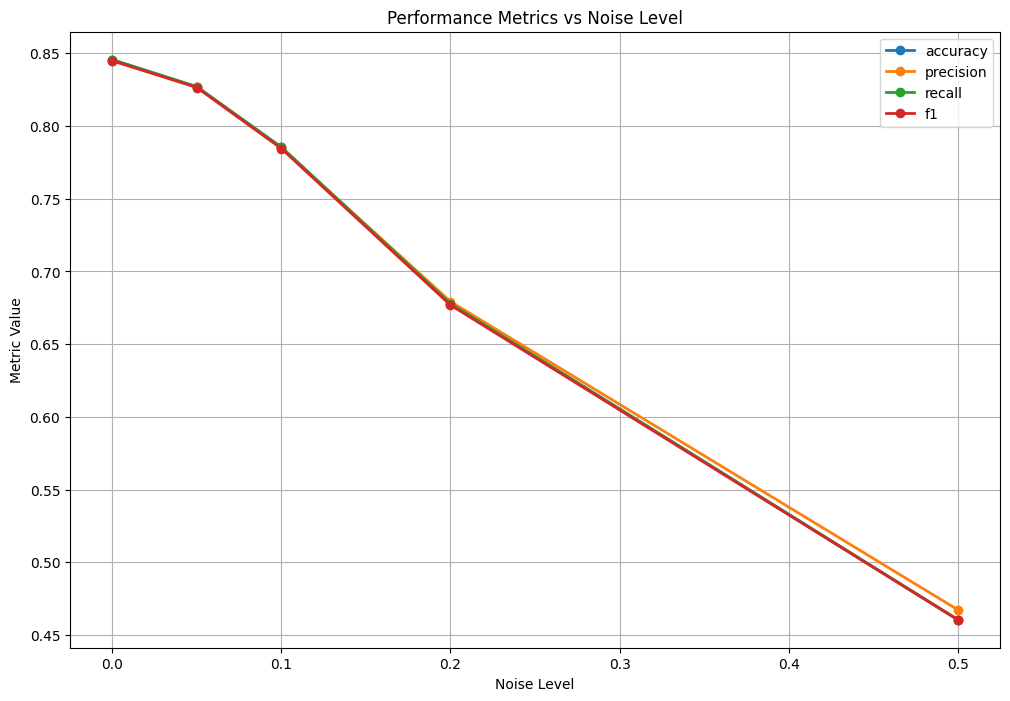

In [12]:
# Plot performance metrics vs noise level
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
plt.figure(figsize=(12, 8))

for metric in metrics_to_plot:
    plt.plot([p['noise_level'] for p in performance_results], 
             [p[metric] for p in performance_results], 
             marker='o', linewidth=2, label=metric)

plt.xlabel('Noise Level')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Noise Level')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/performance_vs_noise.png', dpi=300, bbox_inches='tight')
plt.show()

# Log plot to MLflow
log_artifact('../reports/figures/performance_vs_noise.png')

## 8. Monitoring Over Time

Let's simulate monitoring the model over time with different data distributions.

In [13]:
# Simulate monitoring over time
n_time_points = 10
metrics_history = []

# Start with original test data
metrics_history.append({
    'timestamp': datetime.now().strftime('%Y-%m-%d'),
    **evaluate_model(model, x_test_flat, y_test_prep, class_names)
})

# Simulate data drift over time
for i in range(1, n_time_points):
    # Gradually increase noise level
    noise_level = i * 0.05
    
    # Add noise to test data
    x_test_drift = x_test_flat + np.random.normal(0, noise_level, x_test_flat.shape)
    
    # Evaluate model on drifted data
    drift_metrics = evaluate_model(model, x_test_drift, y_test_prep, class_names)
    
    # Add timestamp (simulate data from different days)
    timestamp = (datetime.now() + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
    
    # Store results
    metrics_history.append({
        'timestamp': timestamp,
        **drift_metrics
    })
    
    print(f"Time point {i}, Noise level: {noise_level}, Accuracy: {drift_metrics['accuracy']:.4f}")

Accuracy: 0.8456
Precision: 0.8449
Recall: 0.8456
F1 Score: 0.8449

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.81      0.78      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.74      0.77      0.75      1000
       Dress       0.85      0.84      0.85      1000
        Coat       0.76      0.77      0.77      1000
      Sandal       0.93      0.94      0.93      1000
       Shirt       0.63      0.56      0.59      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.92      0.93      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.84      0.85      0.84     10000

Accuracy: 0.8255
Precision: 0.8253
Recall: 0.8255
F1 Score: 0.8251

Classification Report:
              precision    recall  f1-score   support

 T-s

Metrics over time plot saved to ../reports/figures/metrics_over_time.png


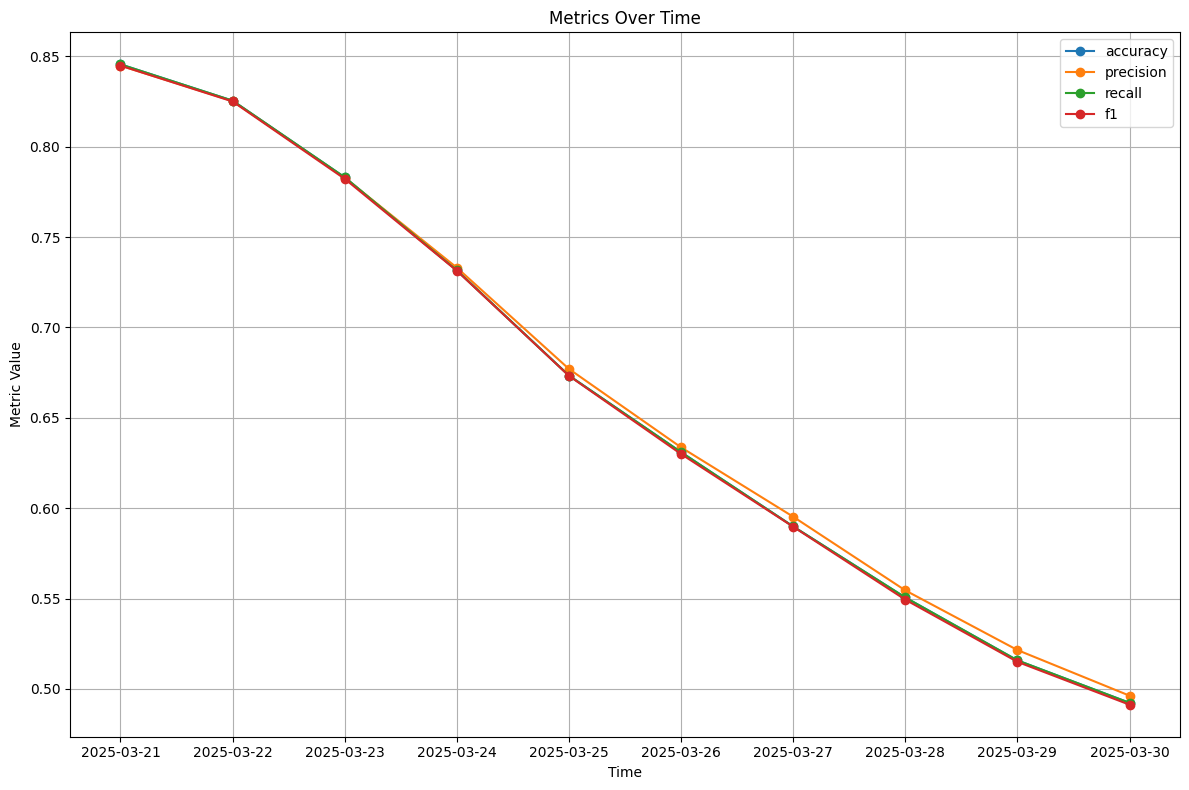

In [14]:
# Plot metrics over time
metrics_df = plot_metrics_over_time(
    metrics_history, 
    output_file='../reports/figures/metrics_over_time.png'
)

# Log plot to MLflow
log_artifact('../reports/figures/metrics_over_time.png')

## 9. Alerting System

Let's implement a simple alerting system that triggers when performance drops below a threshold.

In [15]:
# Define alerting thresholds
alert_thresholds = {}
for metric in config['metrics']:
    alert_thresholds[metric['name']] = metric['threshold']

print("Alert thresholds:")
for metric, threshold in alert_thresholds.items():
    print(f"  {metric}: {threshold}")

# Check for alerts in metrics history
alerts = []
for i, metrics in enumerate(metrics_history):
    timestamp = metrics['timestamp']
    for metric, threshold in alert_thresholds.items():
        if metric in metrics and metrics[metric] < threshold:
            alerts.append({
                'timestamp': timestamp,
                'metric': metric,
                'value': metrics[metric],
                'threshold': threshold
            })

# Display alerts
if alerts:
    print("\nAlerts detected:")
    for alert in alerts:
        print(f"  {alert['timestamp']}: {alert['metric']} = {alert['value']:.4f} (below threshold {alert['threshold']})")
else:
    print("\nNo alerts detected.")

Alert thresholds:
  accuracy: 0.85
  precision: 0.85
  recall: 0.85
  f1: 0.85
  roc_auc: 0.9

Alerts detected:
  2025-03-21: accuracy = 0.8456 (below threshold 0.85)
  2025-03-21: precision = 0.8449 (below threshold 0.85)
  2025-03-21: recall = 0.8456 (below threshold 0.85)
  2025-03-21: f1 = 0.8449 (below threshold 0.85)
  2025-03-22: accuracy = 0.8255 (below threshold 0.85)
  2025-03-22: precision = 0.8253 (below threshold 0.85)
  2025-03-22: recall = 0.8255 (below threshold 0.85)
  2025-03-22: f1 = 0.8251 (below threshold 0.85)
  2025-03-23: accuracy = 0.7831 (below threshold 0.85)
  2025-03-23: precision = 0.7829 (below threshold 0.85)
  2025-03-23: recall = 0.7831 (below threshold 0.85)
  2025-03-23: f1 = 0.7823 (below threshold 0.85)
  2025-03-24: accuracy = 0.7316 (below threshold 0.85)
  2025-03-24: precision = 0.7331 (below threshold 0.85)
  2025-03-24: recall = 0.7316 (below threshold 0.85)
  2025-03-24: f1 = 0.7314 (below threshold 0.85)
  2025-03-25: accuracy = 0.6734 (bel

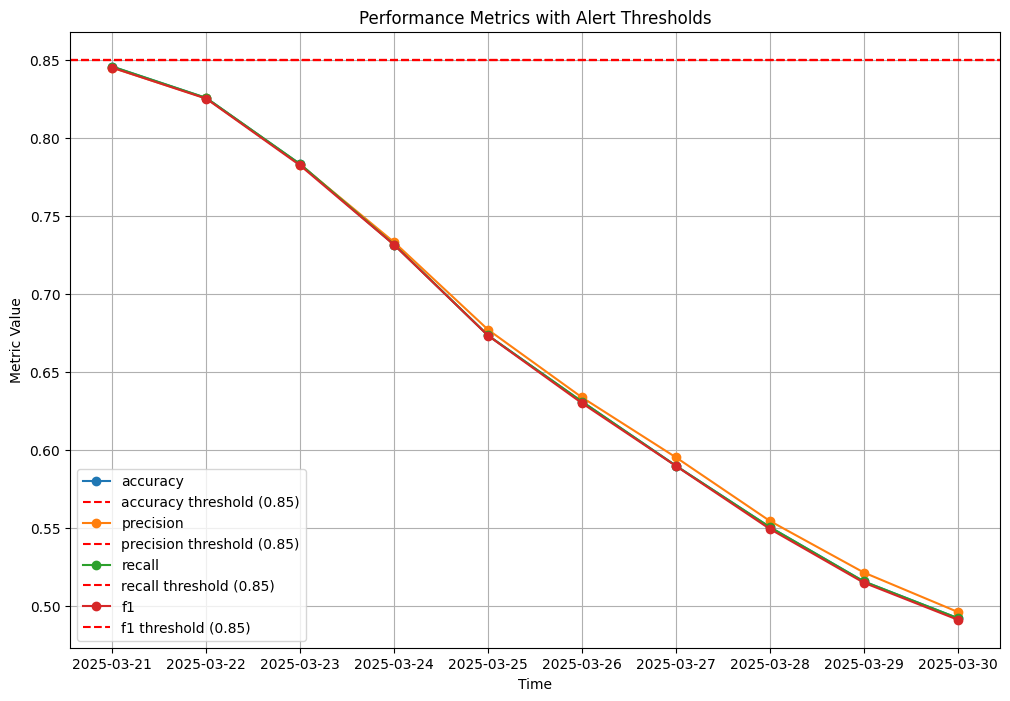

In [16]:
# Visualize alerts
plt.figure(figsize=(12, 8))

# Plot metrics
for metric in alert_thresholds.keys():
    if metric in metrics_df.columns:
        plt.plot(metrics_df.index, metrics_df[metric], marker='o', label=metric)
        
        # Plot threshold line
        plt.axhline(y=alert_thresholds[metric], linestyle='--', color='red', 
                   label=f"{metric} threshold ({alert_thresholds[metric]})")

plt.xlabel('Time')
plt.ylabel('Metric Value')
plt.title('Performance Metrics with Alert Thresholds')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/metrics_with_alerts.png', dpi=300, bbox_inches='tight')
plt.show()

# Log plot to MLflow
log_artifact('../reports/figures/metrics_with_alerts.png')

## 10. Model Retraining Recommendation

Based on the monitoring results, let's implement a simple model retraining recommendation system.

In [17]:
# Define retraining criteria
def recommend_retraining(metrics_history, alert_thresholds, consecutive_alerts=2):
    """
    Recommend model retraining based on monitoring results.
    
    Parameters
    ----------
    metrics_history : list of dict
        List of metrics dictionaries, each representing a time point.
    alert_thresholds : dict
        Dictionary of metric thresholds.
    consecutive_alerts : int, default=2
        Number of consecutive alerts to trigger retraining recommendation.
        
    Returns
    -------
    tuple
        (recommend_retraining, reason) whether to recommend retraining and the reason.
    """
    # Check for consecutive alerts
    consecutive_alert_count = {metric: 0 for metric in alert_thresholds}
    
    for metrics in metrics_history:
        for metric, threshold in alert_thresholds.items():
            if metric in metrics and metrics[metric] < threshold:
                consecutive_alert_count[metric] += 1
                if consecutive_alert_count[metric] >= consecutive_alerts:
                    return True, f"{metric} below threshold for {consecutive_alerts} consecutive time points"
            else:
                consecutive_alert_count[metric] = 0
    
    # Check for significant performance drop
    if len(metrics_history) >= 2:
        first_metrics = metrics_history[0]
        last_metrics = metrics_history[-1]
        
        for metric in alert_thresholds:
            if metric in first_metrics and metric in last_metrics:
                drop = first_metrics[metric] - last_metrics[metric]
                if drop > 0.1:  # 10% drop in performance
                    return True, f"{metric} dropped by {drop:.2%} since monitoring began"
    
    return False, "No retraining needed"

# Check if retraining is recommended
recommend, reason = recommend_retraining(metrics_history, alert_thresholds)

print(f"Retraining recommendation: {'Yes' if recommend else 'No'}")
print(f"Reason: {reason}")

Retraining recommendation: Yes
Reason: accuracy below threshold for 2 consecutive time points


## 11. End MLflow Run

In [18]:
# End MLflow run
mlflow.end_run()
print(f"MLflow run ended: {run_id}")

MLflow run ended: f86d33417e5444fd8f46c63b7b4e0063


## 12. Summary of Findings

In this notebook, we've explored various model monitoring and performance tracking techniques for the Fashion MNIST dataset:

### MLflow Integration:

1. **Experiment Tracking**: We used MLflow to track experiments, log model parameters, metrics, and artifacts.
2. **Model Registry**: We logged the trained model to MLflow, making it easy to retrieve and deploy.

### Drift Detection:

1. **Feature Drift**: We detected feature drift using the Kolmogorov-Smirnov test, which identified when the distribution of features changed.
2. **Performance Drift**: We monitored how model performance metrics changed over time and detected when they dropped below acceptable thresholds.

### Monitoring Visualization:

1. **Drift Visualization**: We created visualizations to understand which features were drifting and how much.
2. **Performance Tracking**: We plotted performance metrics over time to identify trends and potential issues.

### Alerting System:

We implemented a simple alerting system that triggers when performance metrics drop below predefined thresholds, helping to identify when model retraining might be necessary.

### Retraining Recommendations:

Based on monitoring results, we provided recommendations for when to retrain the model, considering factors like consecutive alerts and significant performance drops.

These monitoring and tracking techniques are essential for maintaining model performance in production environments, where data distributions can change over time and affect model accuracy.